In [1]:
import pygame
import numpy as np
import itertools
from itertools import product
from matplotlib import pyplot as plt 
import pandas as pd 
from statistics import median 

pygame 2.6.1 (SDL 2.28.4, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Grid:
    """
    Class for the grid underlying the snake. 
    Using base height and width, orientations are: 
    top right: 17, 0 
    top left: 0, 0
    bottom left: 0, 17
    bottom right: 17, 17
    """
    def __init__(self, width=18, height=18):
        self.width = width
        self.height = height
    
    def spawn_food(self, snake):
        grid = self.get_grid(snake)
        coords = np.column_stack(np.where(grid == -1))

        # Randomly select one of these coordinates
        if coords.size > 0:  # Ensure there are valid coordinates
            selected_index = np.random.choice(len(coords))
            x, y = coords[selected_index]
        else: 
            return np.array([-1, -1])
        return np.array([x, y])
    
    def get_grid(self, snake):
        grid = np.full((self.height, self.width), -1, dtype=int)
        for x, y in snake.body:
            grid[y, x] = -5
        
        if snake.food is not None:
            fx, fy = snake.food
            grid[fy, fx] = 100
        return grid

In [3]:
class Snake:
    """
    Class for the Snake. 
    The Snake has an underlying grid, a body consisting of its head and segments, a memory for movements and 
    a counter for moves. 
    
    Game rule: 
        The goal for the snake is to feed on as many foods as possible until death. 
        Death occurs as soon as the head of the snake touches another segment.
        As soon as the snake eats food, the snake grows and another food spawns.
        The Snake can move up, down, right and left.  
    Additional rule: 
        There are no boarders in this implementation of the snake game. The snake can move out through 
        one side and will enter through the opposing side. This transitions the typical game view from 
         ___      __ ___ __
        |_S_| to |__|___|__| where S marks where the snake lives. 
                 |__|_S_|__| This view of the map makes it possible for us to assigne distances, or visually them
                 |__|___|__| atleast. 
    Rewards: 
        The Snake is rewarded for eating food. The reward is generous with a value of 20, 
        since it is the only reward the snake will get. 
        The closer the snake moves to the food, the less penalty it will get. Additionally, 
        the longer the snakes takes to get to the food, the higher the penalty will be. 
        The closer it gets to the food, the less penalty it gets. 
        
        The penalty is calculates via the function penalty(x) = cos(1/sqrt(x + p))**2.
        The penalty should be low and bounded, so the snake does not give up on live and just 
        tries to kill itself instead of chasing food. The penalty is shifted such that it is in 
        the inteval [0, 1]. 
    Game Over: 
        The Game ends as soon as the snake touches itself. Other failsafe is build in. If the snakes makes too
        many movements without eating, it starves and the game is over.,
    Information: 
        The state of the game is defined by the information the Learner gets. 
        The snake will only know in which direction the food will be (top left, top, bottom right, etc). 
        There will be no information about the distance. Additionally, the snake will locate the 
        neighbouring segments in a 4x4 grid around the head. 
        This is not suitable for long time games but it will hold the state space small, 
        sucht that learning is feasable. 
    Action: 
        The snake is forbidden to walk into itself if possible. In testing, it was too hard for 
        the snake to learn this rule, so I forbid it and now the snake tries to avoid 
        ending the game for as long as possible.
        
    """
    def __init__(self, grid: Grid):
        self.grid = grid
        self.grid_dimension = min(self.grid.height, self.grid.width)
        
        # location of the other grid depicted in the docstring
        self.additional_grid_dimensions = list(itertools.product(
            [self.grid.height, -self.grid.height, 0], 
            [self.grid.width, -self.grid.width, 0]))
        self.additional_grid_dimensions = np.array([self.additional_grid_dimensions[i] for i in range(len(self.additional_grid_dimensions))])
        
        self.body = [np.array([grid.width // 2, grid.height // 2])]  # Snake starts in the center
        self.food = None
        self.food = self.grid.spawn_food(self)
        self.direction = np.array([0, -1])  # Default direction: moving up
        self.history = [self.grid.get_grid(self)]
        self.game_over = False
        self.movement_history = []
        self.moves = 0
        self.echorange = 2
        
    def reset(self):
        """
        Reset snake into base configuration.
        """ 
        self.body = [np.array([self.grid.width // 2, self.grid.height // 2])]
        self.food = None 
        self.food = self.grid.spawn_food(self)
        self.direction = np.array([0, -1])  # Default direction: moving up
        self.history = [self.grid.get_grid(self)]
        self.game_over = False
        self.movement_history = []
        self.moves = 0

    
    def get_positional_reward(self, new_head):
        if (self.food[0] == new_head[0]) and (self.food[1] == new_head[1]):   # If it eats the food
            return self.grid_dimension
        
        def penalty(x): 
            """
            See docstring above. 
            x + p with p = 1/arcos(minpenalty)**2 sets the range onto the interval 
            [min_penalty, 1]
            """
            return np.cos(1/np.sqrt(x + (2/np.pi)**2 - 1))**2   

        
        distance = np.min(self.get_distances(new_head))
        
        trajectory_penalty = 0
        if len(self.movement_history) > self.grid_dimension: 
            # Penalty for moving in one direction too much (in a row)
            trajectory_penalty = 1 # penalty(len(self.movement_history)-18)
        mvm_penalty = penalty(self.moves)
        distance_penalty = penalty(distance)

        return - distance_penalty * (trajectory_penalty + mvm_penalty)
    
    def get_distances(self, head = None, food = None):
        if head is None: 
            head = self.body[0]
        if food is None:
            food = self.food
        # Using the graph in the docstring, all distances are calculated. 
        # One can then take the minimum distance as the nearest distance between food and snake
        distances = [np.sum(np.abs(head - (food + self.additional_grid_dimensions[i]))) for i in range(len(self.additional_grid_dimensions))]
        return distances

    
    def get_actions(self):
        """
        Check if there are segments around the snake and cancel all action that 
        result in moving the head into the body, aka game_over 
        """
        head = self.body[0]
        area = ((-1, 0), (1, 0), (0, -1), (0, 1))       # l, r, u, d
        direction_mapping = {
            (-1, 0): "l",
            (1, 0): "r", 
            (0, -1): "u", 
            (0, 1): "d"
        }

        allowed_directions = []
        for orientation in area: 
            add_bool = True
            x, y = orientation
            col_coordinate = np.mod(head[0] + x, self.grid.height)  # Taking mod, because the snake could 
            row_coordinate = np.mod(head[1] + y, self.grid.width)   # be in another grid (doc string graph)

            for segment in self.body: 
                if np.array_equal(segment, (col_coordinate, row_coordinate)): 
                    add_bool = False
            
            if add_bool: 
                allowed_directions.append(direction_mapping[(x, y)])
                
        
        return allowed_directions if len(allowed_directions) > 0 else [np.random.choice(["l", "u", "r", "d"])]
    
    def get_state(self): 
        """ Idea: Closest direction of food + Amount of body segments in 4x4 area.
            -1, 1          # Food is left bottom

             1, 1          # Food is right bottom

            -1, -1         # Food is left top

             1, -1         # Food is right top
        Returns:
            _type_: _description_
        """
        
        # Get direction of food. 
        
        distances = self.get_distances()
        nearest_quadrant = self.additional_grid_dimensions[np.argmin(distances)]
        
        food = self.food 
        head = self.body[0]
        
        quadrant_mapping = {
            (0, 1): (1, -1),
            (0, -1): (1, -1),
            (1, 0): (-1, 1),
            (-1, 0): (-1, 1),
            (1, -1): (-1, -1), 
            (1, 1): (-1, -1),
            (-1, 1): (-1, -1), 
            (-1, -1): (-1, -1),
            (0, 0): (1, 1)
        }
        quadrant = (
            bool(nearest_quadrant[0] > 0) - bool(nearest_quadrant[0] < 0), bool(nearest_quadrant[1] > 0) - bool(nearest_quadrant[1] < 0)
            )
        
        reflection = quadrant_mapping[quadrant]
        
        direction = (
            bool(food[0] > head[0]) - bool(food[0] < head[0]), bool(food[1] > head[1]) - bool(food[1] < head[1])
            )
        
        area = np.arange(1 - self.echorange, self.echorange)
        echo = np.zeros((len(area), len(area)))

        for i, x in enumerate(area): 
            for j, y in enumerate(area): 
                col_coordinate = np.mod(head[0] + x, self.grid.height) 
                row_coordinate = np.mod(head[1] + y, self.grid.width)

                
                for segment in self.body: 
                    if np.array_equal(segment, (col_coordinate, row_coordinate)): 
                        echo[j, i] = 1
        
        # blend corners
        if self.echorange > 2:
            echo[0][0] = 0
            echo[0][-1] = 0
            echo[-1][0] = 0
            echo[-1][-1] = 0
        
        return (direction[0]*reflection[0], direction[1]*reflection[1], tuple(map(tuple, echo)))
    
    def execute(self, action):
        """
        Execute an action. Determines if game is over or not. 
        """
        reward = 0
        self.movement_history.append(action)
        if len(np.unique(self.movement_history)) > 1: 
            self.movement_history = [action]
            
        # Map input to direction (left, up, right, down)
        directions = {
            "l": np.array([-1, 0]), 
            "u": np.array([0, -1]), 
            "r": np.array([1, 0]), 
            "d": np.array([0, 1])
        }
        # if action in directions:
        #     move = directions[action]
        #     # Prevent reversing direction
        #     if not np.array_equal(move, -self.direction):
        #         self.direction = move
        self.direction = directions[action]       # Translating the command into additive instructions for the snake
        
        # Compute new head position
        new_head = np.mod(self.body[0] + self.direction, self.grid_dimension)
        
        self.moves += 1
            
        # Check for collisions
        if any(np.array_equal(new_head, segment) for segment in self.body):
            reward -= 150
            self.game_over = True
        
        # Game ends if too many moves without success
        if self.moves > self.grid.height * 5: 
            reward -= 100 
            self.game_over = True 
                    
        # Move the snake
        self.body.insert(0, new_head)

        reward += self.get_positional_reward(new_head)
        state = self.get_state()
        
        # Check if food is eaten
        if np.array_equal(new_head, self.food):
            while np.any(np.all(self.body == self.food, axis=1)):
                self.food = self.grid.spawn_food(self)
                                
            if np.array_equal(self.food, [-1, -1]):
                self.game_over = True 
                reward = 1000
                print("Game Won!")
            self.moves = 0
        else:
            self.body.pop()  # Remove tail if no food eaten
        
        self.history.append(self.grid.get_grid(self))
        return state, reward

## Q Learning

In [4]:
class QValues(object):

    def __init__(self):
        '''Initialize with empty lookup table.'''
        self.values = {}
        
        self.policy = {}

    def get_value(self, state, action):
        '''Return stored q value for (state, action) pair or a random number if unknown.'''
        if not state in self.values:
            self.values[state] = {}
        if not action in self.values[state]:
            self.values[state][action] = abs(np.random.randn()) + 1
            # direction = (state[0], state[1])
            # area = state[2]

            # filtered_states= [key[2] for key in self.values.keys() if (key[0], key[1]) == direction]          # States where the direction is the same as the current direction
            # # Case: There are no other values for that direction (Only needed for the beginning)
            # if len(filtered_states) == 0: 
            #     self.values[state][action] = abs(np.random.randn()) + 1
            #     return self.values[state][action]
            
            # area_array = np.array(area).flatten()
            # target_areas = [np.array(tup).flatten() for tup in filtered_states]
            
            # distances = [np.sum(ar != area_array) for ar in target_areas]
            
            # closest_index = np.argmin(distances)
            # closest_area =  filtered_states[closest_index]
            
            # if action in self.values[(*direction, closest_area)]:
            #     self.values[state][action] = self.values[(*direction, closest_area)][action]
            # else: 
            #     self.values[state][action] = abs(np.random.randn()) + 1
                
        return self.values[state][action]

    def set_value(self, state, action, value):
        '''Stored q value for (state, action) pair.'''
        if not state in self.values:
            self.values[state] = {}
        if not action in self.values[state]:
            self.values[state][action] = 0
        self.values[state][action] = value

    def max_action(self, state, actions, learning=True):
        '''Return the action with highest q value for given state and action list.'''
        if not learning and not state in self.values:
            return np.random.choice(actions) if actions else None

        max_value = -np.inf
        max_action = actions[0] if actions else None
        for action in actions:
            if not learning and not action in self.values[state]:
                continue

            value = self.get_value(state, action)
            if value > max_value:
                max_value = value
                max_action = action
            elif value == max_value and learning:
                max_action = np.random.choice([max_action, action])
        return max_action
    
    def draw_action_from_policy(self, state, actions):
        '''
        Sets all probabilites for the given state. Based on these 
        probabilities, sample an action. 
        Uses softmax function. Categorizes the four possible action into classes 
        and distributes probabilites onto them
        '''
        return self.max_action(state, actions)
        # q_values = {action: np.exp(self.get_value(state, action)) for action in actions}
        # standardizing_val = np.sum(list(q_values.values()))
        # for action in actions: 
        #     if (state, action) not in self.policy: 
                #self.policy[(state, action)] = q_values[action] / standardizing_val
        # return np.random.choice(actions, p=[self.policy[(state, action)] for action in actions])

    def epsilon_greedy(self, state, actions, epsilon):
        '''Returns max_action or random action with probability of epsilon.'''
        if np.random.rand() < epsilon:
            return np.random.choice(actions)
        return self.draw_action_from_policy(state, actions)

    def __str__(self):
        nr_states = len(self.values.keys())
        return 'Number of states: {}'.format(nr_states)

In [5]:
def q_learning(snake: Snake, q=None, nr_episodes=5000, nr_steps=800, epsilon=0.1, alpha=0.1, gamma=0.98, verbose=0):
    if not q:
        q = QValues()

    foods_eaten = []
    
    intervals = nr_episodes // 10
    
    snake.learning = True
    for ep in range(nr_episodes):
        snake.reset()
        steps = 0
        while not snake.game_over:
            # Get state and all possible actions
            t = steps / nr_steps
            eps = epsilon*(1 - t) + t*0.1
            state = snake.get_state()
            actions = snake.get_actions()

            # Sample an action and evaluate it
            action = q.epsilon_greedy(state, actions, eps)
            q_old = q.get_value(state, action)
            _, reward = snake.execute(action) # take action
            

            
            # From the new state, get the best action possible and evaluate it 
            next_state = snake.get_state()
            next_max_action = q.max_action(next_state, snake.get_actions())
            q_next = q.get_value(next_state, next_max_action)

            # Update 
            q_new = q_old + alpha * (reward + gamma * q_next - q_old)
            q.set_value(state, action, q_new)
            

            
            if steps == nr_steps: 
                break
            steps += 1
        foods_eaten.append(len(snake.body))
        
        if verbose == 1:
            if (ep + 1) % intervals == 0: 
                print("Done with episode ", ep+1)

    return q, foods_eaten


In [6]:
def visualize_snake(grid_states,score=None, cell_size=18, values=None, speed=80):
    pygame.init()
    width, height = len(grid_states[0][0]) * cell_size, len(grid_states[0]) * cell_size
    screen = pygame.display.set_mode((width, height))
    font = pygame.font.SysFont(None, 24)
    
    for i, grid in enumerate(grid_states):
        screen.fill((0, 0, 0))  # Clear screen
        
        # Draw grid, snake and food
        for y, row in enumerate(grid):
            for x, cell in enumerate(row):
                color = (0, 255, 0) if cell == -5 else (255, 0, 0) if cell == 100 else (0, 0, 0)
                pygame.draw.rect(screen, color, (x * cell_size, y * cell_size, cell_size, cell_size))
        # Display the rewards in top right
        if values is not None: 
            # Display the value on the top left corner
            value_text = font.render(f"Value: {values[i]}", True, (255, 255, 255))
            screen.blit(value_text, (10, 10))
        if score is not None: 
            value_text = font.render(f"Value: {score[i]}", True, (255, 255, 255))
            screen.blit(value_text, (10, 30))
            
            
        pygame.display.flip()       # Updates the hole screen. Does not flip it
        pygame.time.delay(speed)  # Delay to visualize movement

    pygame.quit()


## Gridsearch

In [7]:
class QLearningTrainer:
    """
    Using this class, we can fit multiple parameter configurations 
    and score them based on the well-doing of the snake. 
    """
    
    def __init__(self):
        self.episodes_for_fitting = 350  # Number of training episodes
        self.number_of_score_runs = 300
        self.grid_size = 18
        self.agent = QValues()
        self.snake_echo = 2
    
    def fit(self, alpha, gamma, epsilon):
        """ Train the Q-learning agent on the given environment (snake game). """
        grid = Grid()  
        snake = Snake(grid)
        self.agent, _ = q_learning(snake, self.agent, nr_episodes=self.episodes_for_fitting, gamma=gamma, alpha=alpha, epsilon=epsilon)
    
    def score(self):
        """ Evaluate performance: return average game score over test runs. """
        grid = Grid(self.grid_size, self.grid_size)
        snake = Snake(grid)
        snake.echorange = self.snake_echo
        
        save_scores = []
        moves_needed = []
        
        for _ in range(self.number_of_score_runs): 
            snake.reset()

            state = snake.get_state()
            mv_cnt = 0
            tmp_moves_needed = []
            while not snake.game_over:
                all_actions = snake.get_actions()
                action = self.agent.max_action(state, all_actions, learning=False)
                _, reward = snake.execute(action)
                mv_cnt += 1
                if reward > 0:
                    tmp_moves_needed.append(mv_cnt)
                    mv_cnt = 0
                state = snake.get_state()
                
            if mv_cnt != 0: 
                 tmp_moves_needed.append(mv_cnt)
            moves_needed.append(np.mean(tmp_moves_needed))
            save_scores.append(len(snake.body) - 1)  # Eating food -> longer body. 
            
        return save_scores, moves_needed

In [8]:
class GridSearch: 
    """
    Use grid search to estimate the best parameters for Qlearning.
    Given a grid of parameters, it fits all combinations into the Learner 
    and scores them (based on the well doing of eating food) 
    """
    def __init__(self, agent_learner, parameter_grid: dict, verbose=0): 
        self.agent_learner = agent_learner 
        self.parameter_grid = parameter_grid
        self.best_params = None
        self.verbose = verbose
        
    def fit(self): 
        # Generate all combinations
        keys = self.parameter_grid.keys()
        combinations = [dict(zip(keys, values)) for values in product(*self.parameter_grid.values())]
        
        print(f"Searching a total of {len(combinations)} combinations.")
        score_saver = {}
        for i, comb in enumerate(combinations): 
            self.agent_learner.fit(**comb)
            saved_scores, _ = self.agent_learner.score()
            score_saver[tuple(comb.items())] = np.mean(saved_scores)    # Saves score for each configuration
            
            if self.verbose == 1: 
                print(f"Combination {i} done. Score = {np.mean(saved_scores)}")
        
        self.best_params = max(score_saver, key=score_saver.get)
        self.best_score = score_saver[self.best_params]
        
        

In [22]:
param_grid = {
    "alpha": [ 0.1, 0.2, 0.3],
    "gamma": [0.8, 0.9, 0.99],
    "epsilon": [0.1, 0.2, 0.3]
}

grid_search = GridSearch(QLearningTrainer(), param_grid, verbose=1)
grid_search.fit() 

# Print best parameters
print("Best Parameters:", grid_search.best_params)


"""
Parameters: param_grid = {
    "alpha": [ 0.1, 0.2, 0.3],
    "gamma": [0.8, 0.9, 0.99],
    "epsilon": [0.1, 0.2, 0.3]
}
"""
# best parameters for 5x5 echo: (('alpha', 0.2), ('gamma', 0.9), ('epsilon', 0.3))

# best parameters for 3x3 echo: Best (('alpha', 0.2), ('gamma', 0.8), ('epsilon', 0.3))     # Score = 44.96

Searching a total of 27 combinations.


TypeError: Snake.get_positional_reward.<locals>.penalty() missing 1 required positional argument: 'threshold'

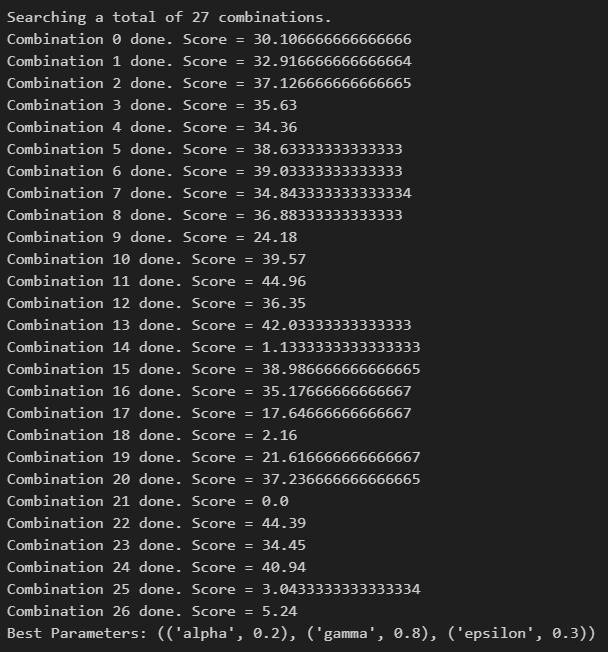

## Evaluation

We are interested in the learning curve. For that, we plot the mean score and the mean moves between scores for different amounts of training episodes. 

We differentiate between the 3x3 and the 5x5 state area around the snakes head. 

In [19]:
from time import time 

save_q = {}
g = Grid()

all_eps = np.arange(1, 101, 2)
#all_eps = np.arange(1, 1202, 100)
for neps in all_eps: 
    S = Snake(g)
    
    S.echorange = 3
    
    t = time()
    q, training_food_eaten = q_learning(S, alpha=0.2, epsilon=0.3, gamma=0.8, nr_episodes=neps)
    save_q[neps] = q
    print(f"{neps} {round(time() - t, 1)}", end="; ")

1 0.1; 3 0.3; 5 0.4; 7 1.0; 9 1.1; 11 1.0; 13 1.2; 15 1.7; 17 1.7; 19 2.6; 21 3.5; 23 4.8; 25 3.6; 27 2.9; 29 4.0; 31 5.8; 33 5.8; 35 5.6; 37 5.8; 39 6.3; 41 8.9; 43 7.4; 45 8.4; 47 10.5; 49 7.7; 51 8.5; 53 10.0; 55 9.7; 57 12.5; 59 12.5; 61 12.5; 63 14.4; 65 12.2; 67 17.2; 69 16.4; 71 13.3; 73 15.3; 75 12.1; 77 13.5; 79 20.2; 81 19.4; 83 19.5; 85 21.5; 87 19.6; 89 17.3; 91 19.9; 93 21.5; 95 24.6; 97 23.9; 99 22.7; 

In [22]:
scores_mean = {}
scores_std = {}
scores_mode = {}

scores_mv_mean = {}
scores_mv_std = {}
scores_mv_mode = {}
print("Current: ", end=" ")
for neps in all_eps:
    print(neps, end=", ")
    QLT = QLearningTrainer()
    QLT.agent = save_q[neps]
    QLT.snake_echo = 3
    saved_scores, saved_needed_moves = QLT.score()
    
    scores_mean[neps] = np.mean(saved_scores)
    scores_std[neps] = np.std(saved_scores)
    scores_mode[neps] = median(saved_scores)
    
    scores_mv_mean[neps] = np.mean(saved_needed_moves)
    scores_mv_std[neps] = np.std(saved_needed_moves)
    scores_mv_mode[neps] = median(saved_needed_moves)

Current:  1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 

In [20]:
def plot_q_statistics(scores_mean, scores_std, scores_median, scores_mv_mean, scores_mv_std, scores_mv_median):
    xaxe_label = []
    yaxe_score_mean = []
    yaxe_score_var = []
    yaxe_score_median = []

    yaxe_mv_mean = []
    yaxe_mv_var = []
    yaxe_mv_median = []

    for key in all_eps:
        xaxe_label.append(str(key))
        yaxe_score_mean.append(scores_mean[key])
        yaxe_score_var.append(scores_std[key])
        yaxe_score_median.append(scores_median[key])
        
        yaxe_mv_mean.append(scores_mv_mean[key])
        yaxe_mv_var.append(scores_mv_std[key])
        yaxe_mv_median.append(scores_mv_median[key])
        
    fig, axe = plt.subplots(nrows = 2, ncols = 3, figsize=(24, 10))
    xaxe = [(i) for i in range(1, len(yaxe_score_mean)+1)]
    axe[0][0].plot(xaxe, yaxe_score_mean) 
    axe[0][1].plot(xaxe, yaxe_score_var)
    axe[0][2].plot(xaxe, yaxe_score_median)

    axe[1][0].plot(xaxe, yaxe_mv_mean)
    axe[1][1].plot(xaxe, yaxe_mv_var)
    axe[1][2].plot(xaxe, yaxe_mv_median)

    axe[0][0].set_xticks(xaxe, xaxe_label, rotation=90, fontsize=7)  
    axe[0][1].set_xticks(xaxe, xaxe_label, rotation=90, fontsize=7) 
    axe[0][2].set_xticks(xaxe, xaxe_label, rotation=90, fontsize=7) 

    axe[1][0].set_xticks(xaxe, xaxe_label, rotation=90, fontsize=7)  
    axe[1][1].set_xticks(xaxe, xaxe_label, rotation=90, fontsize=7) 
    axe[1][2].set_xticks(xaxe, xaxe_label, rotation=90, fontsize=7) 

    axe[0][0].set_title("Means (Score)")
    axe[0][1].set_title("Standard-deviation(Score)")
    axe[0][2].set_title("Median (Score)")

    axe[1][0].set_title("Means (Moves)")
    axe[1][1].set_title("Standard-deviation (Moves)")
    axe[1][2].set_title("Median (Moves)")
    fig.savefig("Snake_5x5Echo_1to100.png")
    plt.show()

#### 3x3 Echo

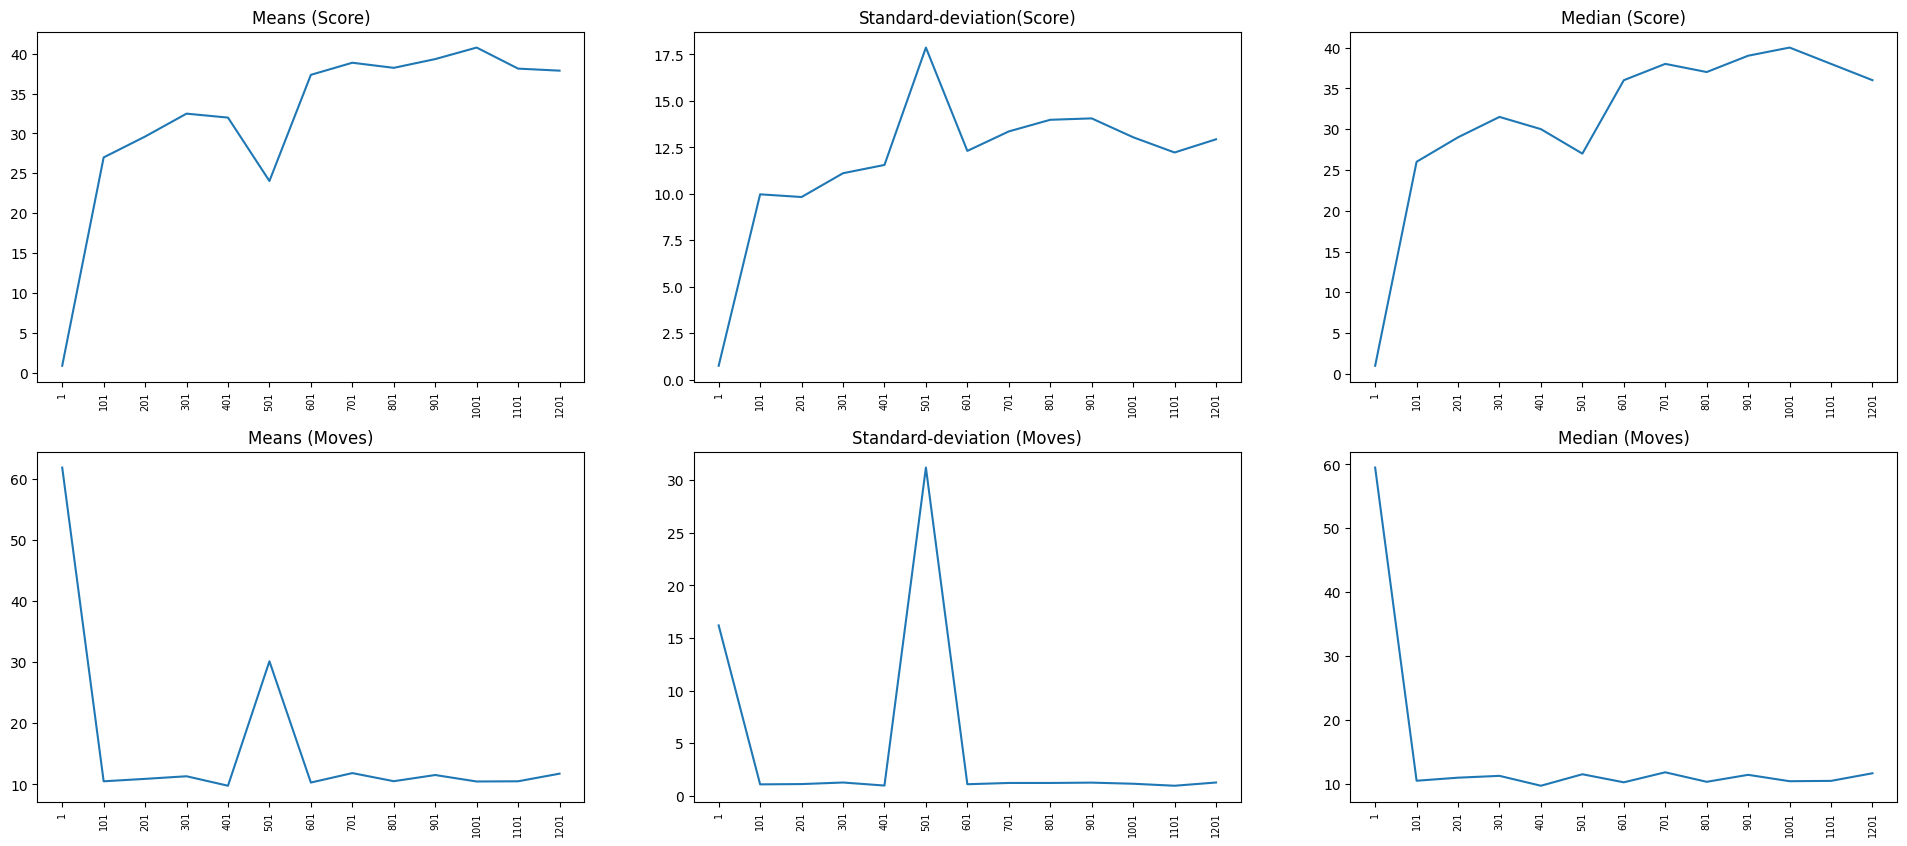

In [29]:
# 3x3 Echo 
# plot_q_statistics(scores_mean,scores_std,scores_mode ,scores_mv_mean ,scores_mv_std ,scores_mv_mode )

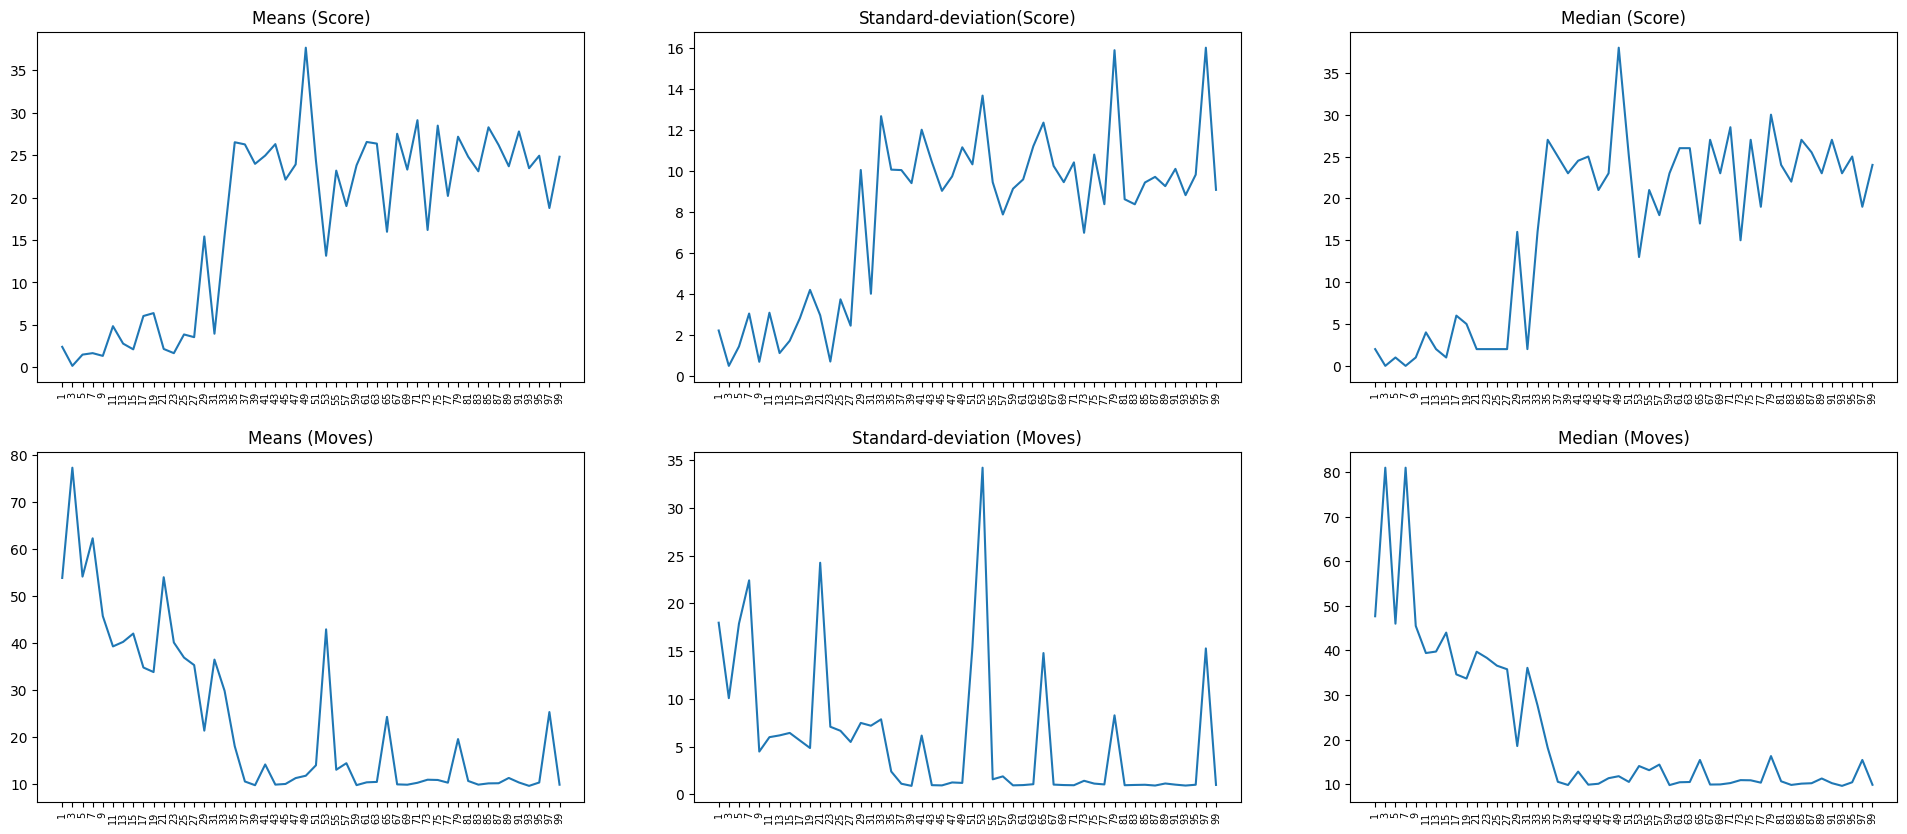

In [33]:
# From 1 to 100 
# plot_q_statistics(scores_mean,scores_std,scores_mode ,scores_mv_mean ,scores_mv_std ,scores_mv_mode)

#### 5x5 Grid

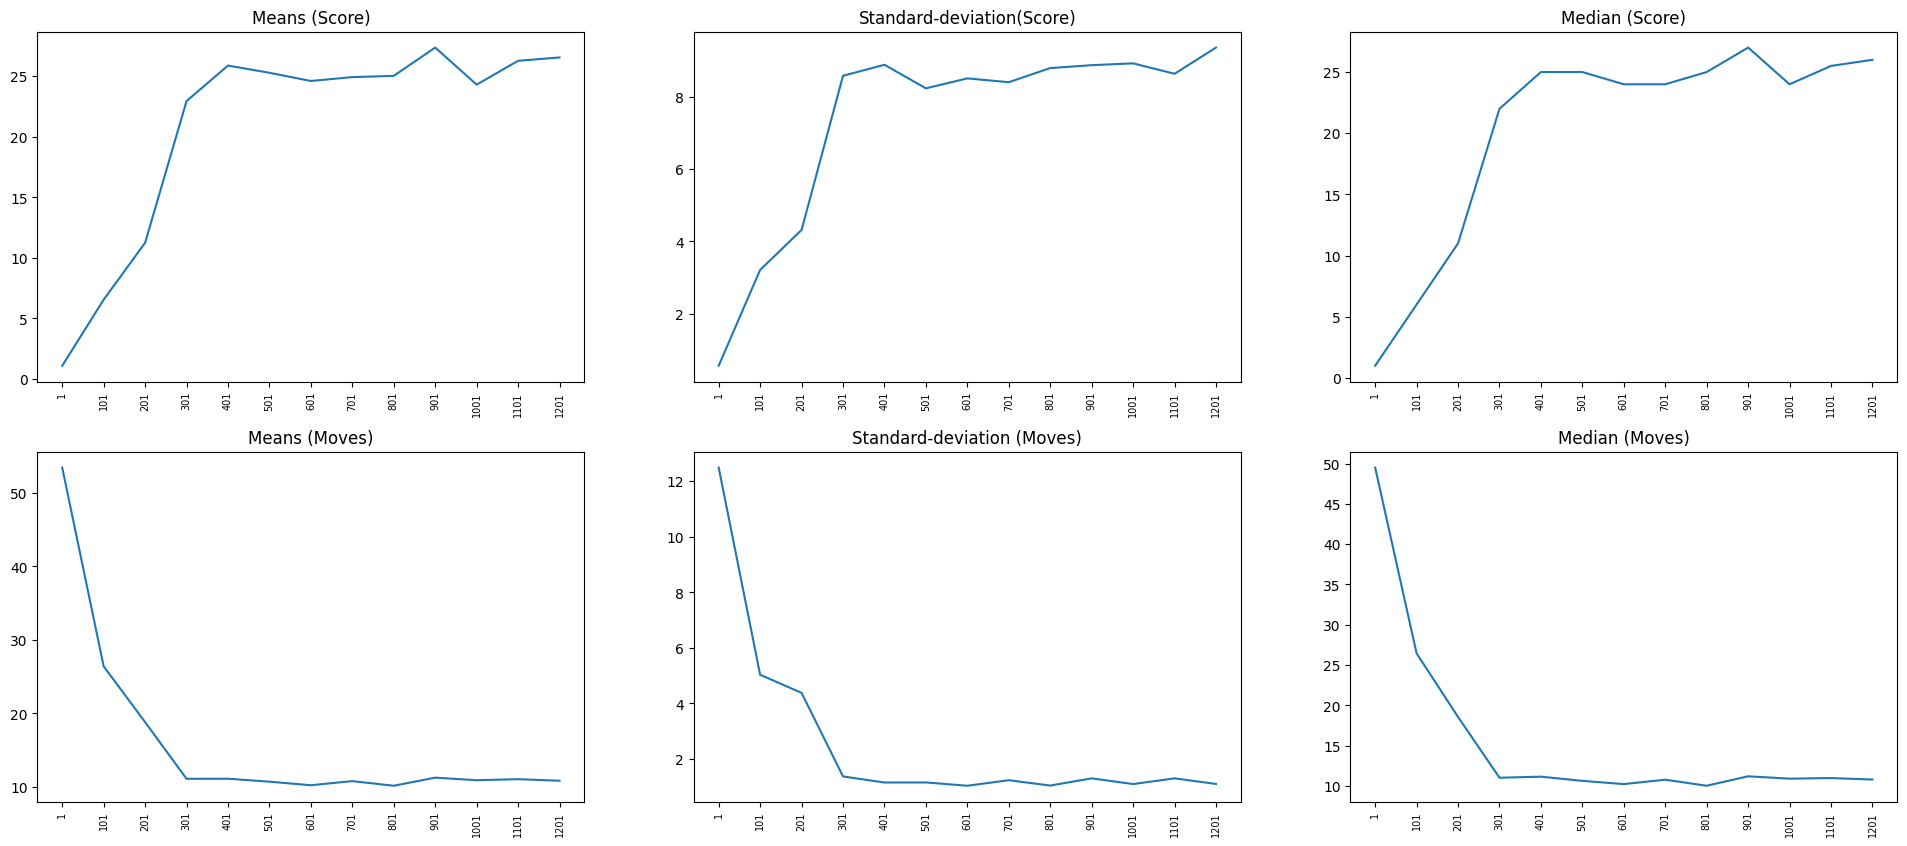

In [18]:
# 5x5 Echo
plot_q_statistics(scores_mean,scores_std,scores_mode ,scores_mv_mean ,scores_mv_std ,scores_mv_mode )

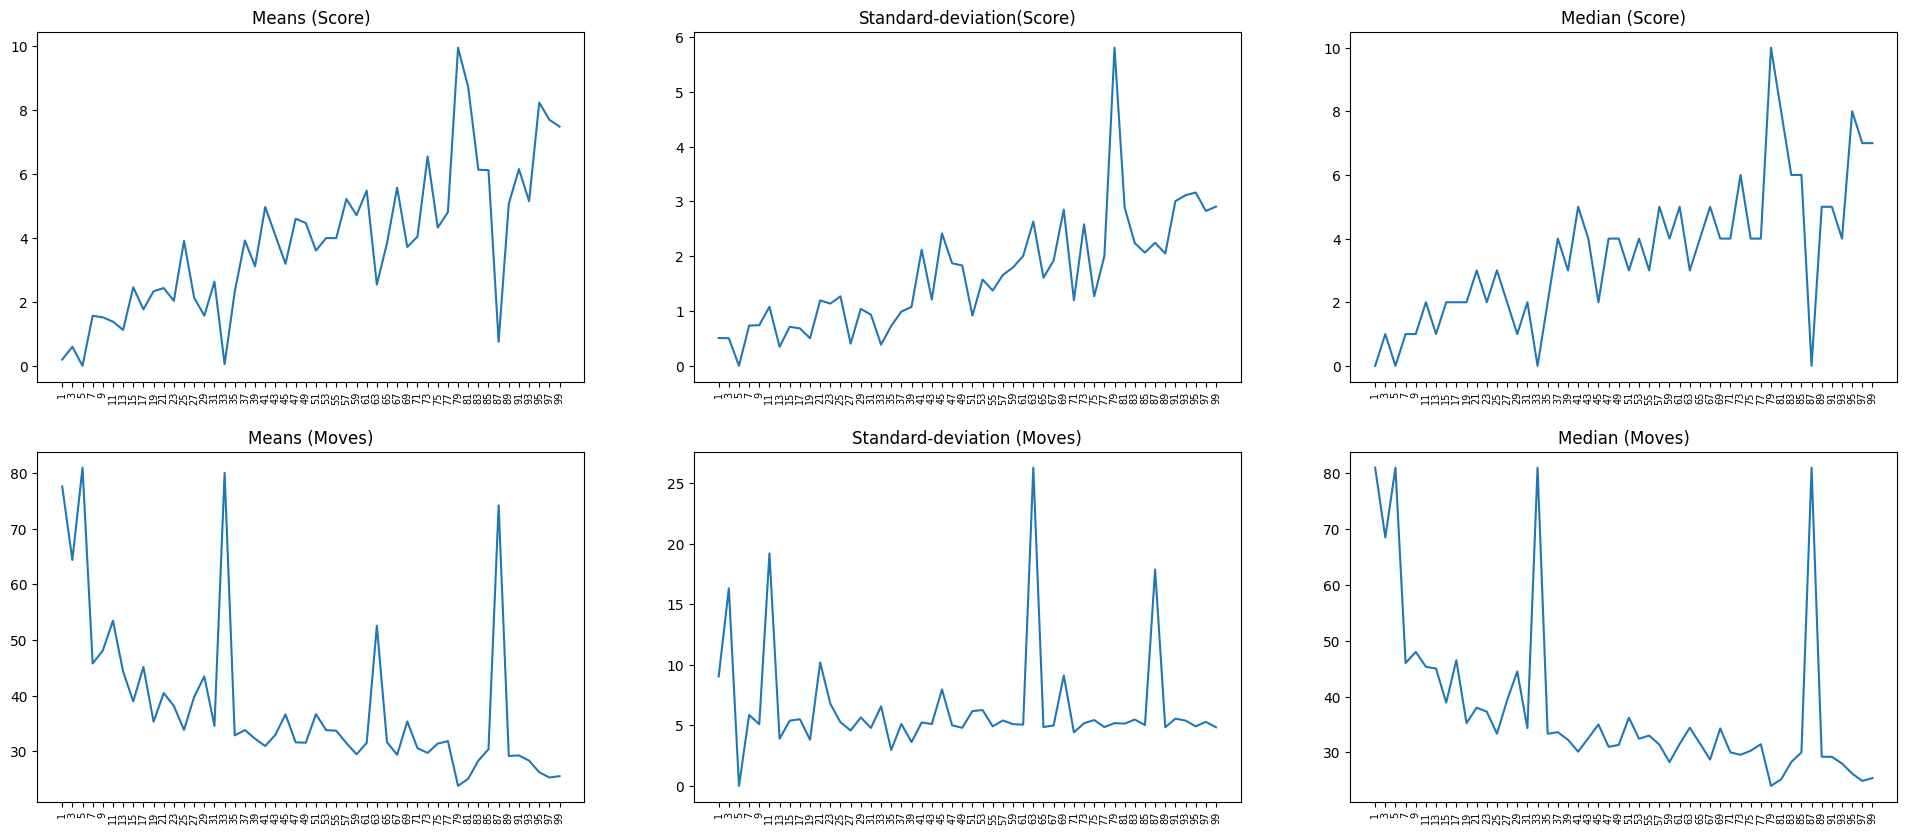

In [23]:
# 5x5 with episodes 1 to 100
plot_q_statistics(scores_mean,scores_std,scores_mode ,scores_mv_mean ,scores_mv_std ,scores_mv_mode )

PLOT

### Trained Snake

In [24]:
g = Grid()
q = QValues()
S = Snake(g)
S.echorange = 2
q_echorange_2, _ = q_learning(S, q, 10000, epsilon=0.3, alpha=0.2, gamma=0.8)
S = Snake(g)
S.echorange = 3
q_echorange_3, _ = q_learning(S, q,  10000, epsilon=0.3, alpha=0.2, gamma=0.9)

#### Saving

In [45]:

def save_q_and_policy(q: QValues, name: str):
    states = list(q.values.keys())
    values = list(q.values.values())

    df = {"States": states, "Values": values}

    pd.to_pickle(pd.DataFrame.from_dict(df), f"E:\\Luca Daten\\Lehrweg\\Uni\\Master\\Semester 3\\ML2\\Final\\{name}_Values.pkl")

    state_action = list(q.policy.keys())
    prob = list(q.policy.values())

    df = {"State/Action": state_action, "Probability": prob}

    pd.to_pickle(pd.DataFrame.from_dict(df), f"E:\\Luca Daten\\Lehrweg\\Uni\\Master\\Semester 3\\ML2\\Final\\{name}_Policy.pkl")



In [50]:
save_q_and_policy(q_echorange_3[0], "Final_Q_Echorange3")

79029


##### Loading

In [10]:
def load_q_and_policy(name: str): 
    states_values_df = pd.read_pickle(f"E:\\Luca Daten\\Lehrweg\\Uni\\Master\\Semester 3\\ML2\\Final\\{name}_Values.pkl")

    values_dict = states_values_df.set_index('States')['Values'].to_dict()

    policy_df = pd.read_pickle(f"E:\\Luca Daten\\Lehrweg\\Uni\\Master\\Semester 3\\ML2\\Final\\{name}_Policy.pkl")
    policy_dict = policy_df.set_index('State/Action')['Probability'].to_dict()

    q_loaded = QValues()
    q_loaded.values = values_dict
    q_loaded.policy = policy_dict
    return q_loaded

In [11]:
q_echorange_2 = load_q_and_policy("Final_Q_Echorange2")
q_echorange_3 = load_q_and_policy("Final_Q_Echorange3")

In [13]:
def test_q_on_grid_sizes(q):
    """
    Test the change of the grid size. Q was learned on a 18x18 Grid.  What happens if we change the size? 
    We look at the percentage the snake  fills the grid, such that we obtain a performance relative to the grid size. 
    """
    best_scores = {}
    mean_scores = {}
    mean_moves = {}
    median_scores = {}
    median_moves = {}
    for size in np.arange(18, 54, 5):
        print("Current: ", size, end=", ")
        QLT = QLearningTrainer()
        QLT.grid_size = size
        QLT.agent = q
        
        QLT.snake_echo = 3
        
        saved_scores, saved_needed_moves = QLT.score()
        best_scores[size] = np.max(saved_scores)
        mean_scores[size] = np.mean(saved_scores)
        mean_moves[size] = np.mean(saved_needed_moves)
        median_scores[size] = median(saved_scores)
        median_moves[size] = median(saved_needed_moves)

    return best_scores, mean_scores, mean_moves, median_scores, median_moves

def plot_test_q_on_grid_size(best_scores, mean_scores, mean_moves, median_scores, median_moves):
    
    sizes = list(best_scores.keys())
    
    fig1, axe1 = plt.subplots(ncols=2, figsize=(8, 6))
    
    yaxe1 = [best_scores[size]/size**2 for size in sizes]
    yaxe2 = [best_scores[size] for size in sizes]
    axe1[0].plot(sizes, yaxe1)
    axe1[0].set_title("Best Score with respect to grid size")
    axe1[0].set_ylabel(r"$\frac{\text{score}}{size^2}$")
    axe1[0].set_xlabel("Gridsize")
    axe1[1].plot(sizes, yaxe2)
    axe1[1].set_title("Best Score")
    axe1[1].set_xlabel("Gridsize")
    axe1[1].set_ylabel("score")
    
    fig2, axe2 = plt.subplots(ncols=2, figsize=(8, 6))
    fig2.suptitle("Statistics of Snake for 3x3 Echo. In reference to grid size")
    titles = ["Mean Score", "Mean Moves", "Median Score", "Median Moves"]
    for i, score in enumerate([mean_scores, mean_moves, median_scores, median_moves]): 

        if "Moves" in titles[i]:
            yaxe = [score[size]/((size**2 - 1)/(3*size)) for size in sizes]
        else: 
            yaxe = [score[size]/size**2 for size in sizes]
        axe2[i%2].plot(sizes, yaxe, label=titles[i])
        axe2[i%2].legend()
    
    plt.show()
        

Mean Moves should be $\frac{n^2 - 1}{3n}$ where n is the grid size. Implement it as the scaling factor of the plots

Test Grid size change von 3x3 learned Q

3x3

In [17]:
#a, b, c, d, e = test_q_on_grid_sizes(q_echorange_2)

Current:  18, Current:  23, Current:  28, Current:  33, Current:  38, Current:  43, Current:  48, Current:  53, 

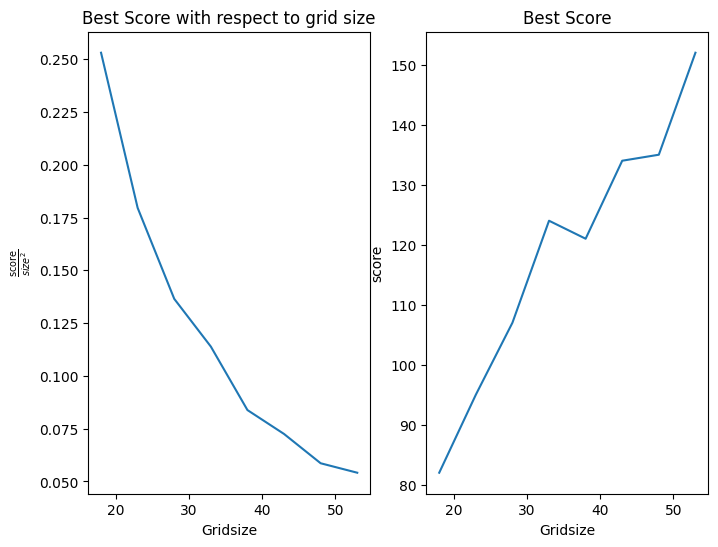

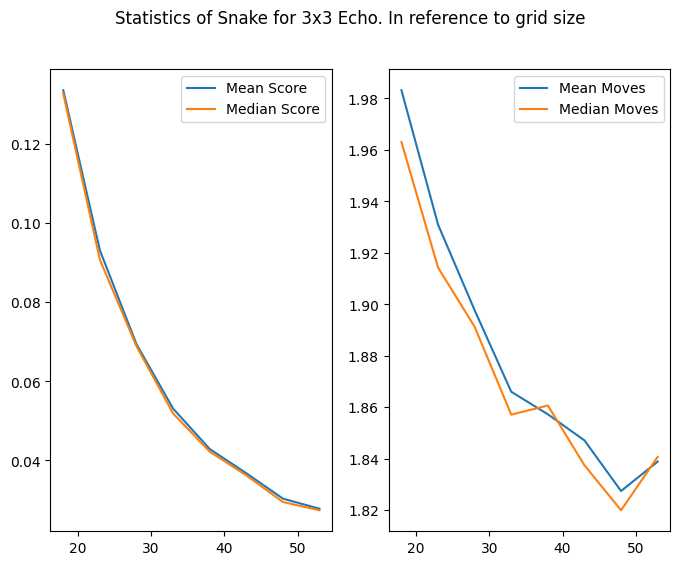

In [48]:
# plot_test_q_on_grid_size(a, b, c, d, e)

Let $n$ be the grid size. The scores got divided by $n^2$ and the moves got divided by $\frac{n^2 - 1}{3n}$, since this is the expected value of the absolut value of the difference of two uniform, discrete random variables. 

In other words: $\mathbb{E}(\|X - Y\|_1) = \frac{n^2 - 1}{3n}$ for $X = (X_1, X_2)$ and $Y=(Y_1, Y_2)$ with $X_i, Y_i \sim U(0, n)$

Conclusion: The score get worse fast but the snake gets better at choosing the fast set of moves to get to the food. The second point can be explained by the size of the grid and less obsticals in the way. 

Test Grid size change von 5x5 learned Q

In [ ]:
# a2, b2, c2, d2, e2 = test_q_on_grid_sizes(q_echorange_3)
# plot_test_q_on_grid_size(a2, b2, c2, d2, e2)

Current:  18, Current:  23, Current:  28, Current:  33, Current:  38, Current:  43, Current:  48, Current:  53, 

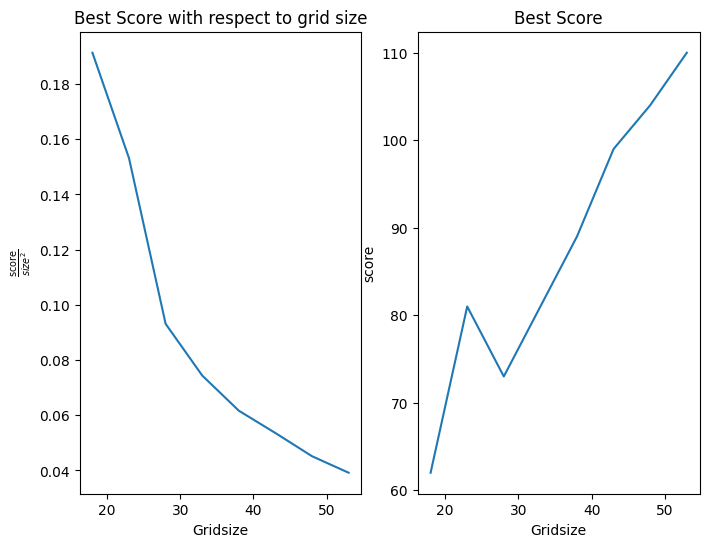

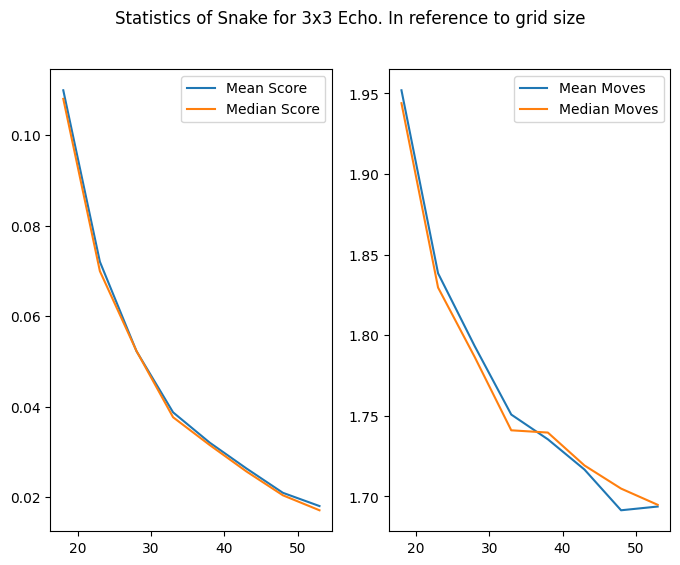

In [15]:
plot_test_q_on_grid_size(a2, b2, c2, d2, e2)

## Example Run

In [49]:
def run_q(Q: QValues, max_run=600, speed=80, grid_size=18):
    """
    Runs a simulation of a given Q and displays it in another window. 
    
    Saves all grid configurations into the Snake.history and displays them afterwards  
    """
    grid = Grid(grid_size, grid_size)
    S = Snake(grid)
    values = [0]
    score = [0]
    for _ in range(max_run):
        state = S.get_state()
        actions = S.get_actions()
        
        action = Q.max_action(state, actions, learning=False)
        
        r = S.execute(action)
        values.append(r[1])
        score.append(len(S.body) - 1)
        if S.game_over: 
            break

    visualize_snake(S.history, score=score, values=values, speed=speed) 

In [50]:
run_q(q_echorange_2, max_run=2000, speed=50)